In [107]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn import manifold
import pickle as pk
from sklearn import linear_model
import time
from skl_groups.features import Features
from skl_groups.summaries import BagOfWords
from sklearn.cluster import KMeans
from sklearn.cross_validation import KFold
from mpl_toolkits.axes_grid1 import *
from sklearn.manifold import LocallyLinearEmbedding
import seaborn as sns
import scipy
from skl_groups.kernels import PairwisePicker, Symmetrize, RBFize, ProjectPSD

%matplotlib inline

In [39]:
# load kernel file
def loadSimilarities(fn):
    """
    Load the previously saved similarity matrix from a .npz file

    Inputs:
    - fn: directory/filename (minus extension) to load the file from

    Returns:
    - loadedSims: similarity matrix
    """
    loader = np.load(fn+".npz")
    print "Similarities loaded!"
    return loader['similarities']

kernelFN = "./simulatedData/kernel-2000-sym-v2"
kl_sym = loadSimilarities(kernelFN)
kernelFN = "./simulatedData/kernel-2000-sym-he"
he_sym = loadSimilarities(kernelFN)
# Note: loaded kernel is the result of
# - building the KNN graph using KL divergence
# - symmeterizing the graph: KL is not a distance and is not symmetric, we need distance-symmetry behavior because next step is...
# - passing the symmeterized graph through a radial basis function (RBF): Since the value of the RBF kernel decreases with distance and ranges between zero (in the limit) and one (when x = x'), it has a ready interpretation as a similarity measure
# - projecting the output of the RBF to a positive semi-definite space: 

Similarities loaded!
Similarities loaded!


0.0 0.0 0.460609


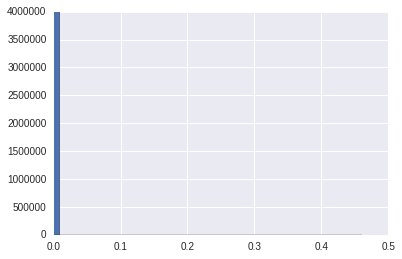

In [40]:
print he_sym.min(), np.median(he_sym.flatten()), he_sym.max()
_ = plt.hist(he_sym.flatten(),50)

0.0 0.792604 1.0
1.0 1.0 1.0


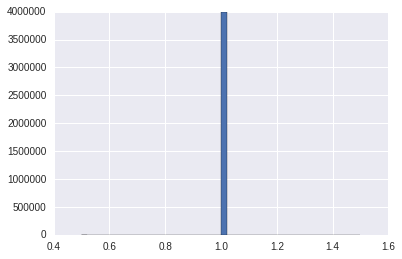

In [51]:
assert (kl_sym == kl_sym.T).all()
assert (he_sym == he_sym.T).all()
rbf = RBFize(gamma=1, scale_by_median=True)
kl_rbf = rbf.fit_transform(kl_sym)
# rbf = RBFize(gamma=1.2, scale_by_median=False)
he_rbf = rbf.fit_transform(he_sym)
print kl_rbf.min(), np.median(kl_rbf), kl_rbf.max()
print he_rbf.min(), np.median(he_rbf), he_rbf.max()
_ = plt.hist(he_rbf.flatten(),50)

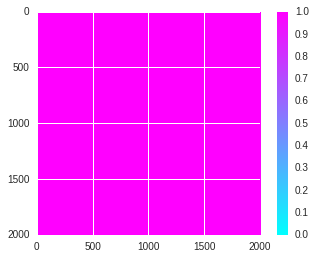

In [52]:
plt.imshow(he_rbf, vmin=0.0, vmax=1.0, cmap='cool')
plt.colorbar()

In [53]:
psd = ProjectPSD()
kernelKL = psd.fit_transform(kl_rbf)
kernelHE = psd.fit_transform(he_rbf)

This is some information the projected kernel :
min, median, max value of the kernel: -0.204198 0.712965 2.06573
less than 0.3 :0.2921085
less than 0.5 :0.3813275
less than 1.0 :0.8088315
-----------
number of subject with at least one entry higher than 1: 2000
These are diagonal elements: [ 1.74616921  1.66733456  1.55396378 ...,  1.59860349  1.69010019
  1.69954538]


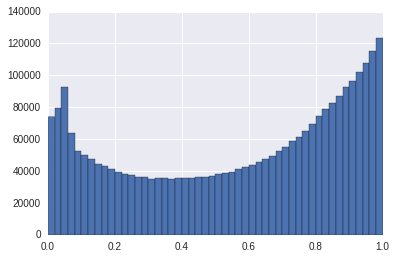

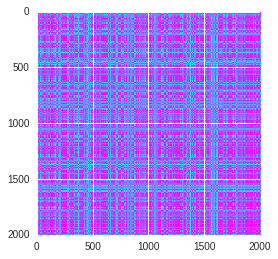

In [54]:
# Numerical checking
print "This is some information the projected kernel :"
print "min, median, max value of the kernel: " + str(np.min(kernelKL)) + " " + str(np.median(kernelKL)) +" "+ str(np.max(kernelKL))
print "less than 0.3 :" + str(np.sum(kernelKL.flatten() < 0.3)/np.float(np.prod(kernelKL.shape)))
print "less than 0.5 :" + str(np.sum(kernelKL.flatten() < 0.5)/np.float(np.prod(kernelKL.shape)))
print "less than 1.0 :" + str(np.sum(kernelKL.flatten() < 1)/np.float(np.prod(kernelKL.shape)))
print "-----------"
print "number of subject with at least one entry higher than 1: " + str( ((kernelKL > 1.0).sum(axis=0)>0).sum())
print "These are diagonal elements: " + str(np.diag(kernelKL))

plt.figure()
# _ = plt.hist(kernel.flatten()[:],50)
_ = plt.hist(kernelKL.flatten()[np.logical_and(kernelKL.flatten() < 1 , kernelKL.flatten() > 0) ],50)


plt.figure()
# plt.imshow(kernel, cmap='cool')
plt.imshow(kernelKL, vmin=0, vmax=1.0, cmap='cool')

This is some information the projected kernel (hellinger):
min, median, max value of the kernel: 0.999593 1.0 1.00075
less than 0.3 :0.2921085
less than 0.5 :0.3813275
less than 1.0 :0.8088315
-----------
number of subject with at least one entry higher than 1: 2000
These are diagonal elements: [ 1.00000048  1.00052392  1.00074625 ...,  1.0000031   1.0000031   1.0000031 ]


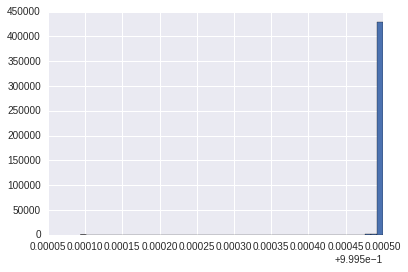

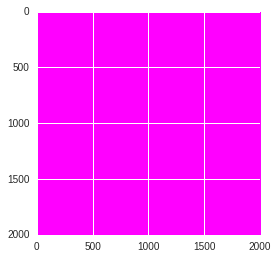

In [55]:
# Numerical checking
print "This is some information the projected kernel (hellinger):"
print "min, median, max value of the kernel: " + str(np.min(kernelHE)) + " " + str(np.median(kernelHE)) +" "+ str(np.max(kernelHE))
print "less than 0.3 :" + str(np.sum(kernelKL.flatten() < 0.3)/np.float(np.prod(kernelHE.shape)))
print "less than 0.5 :" + str(np.sum(kernelKL.flatten() < 0.5)/np.float(np.prod(kernelHE.shape)))
print "less than 1.0 :" + str(np.sum(kernelKL.flatten() < 1)/np.float(np.prod(kernelHE.shape)))
print "-----------"
print "number of subject with at least one entry higher than 1: " + str( ((kernelHE > 1.0).sum(axis=0)>0).sum())
print "These are diagonal elements: " + str(np.diag(kernelHE))

plt.figure()
# _ = plt.hist(kernel.flatten()[:],50)
_ = plt.hist(kernelHE.flatten()[np.logical_and(kernelHE.flatten() < 1 , kernelHE.flatten() > 0) ],50)


plt.figure()
# plt.imshow(kernel, cmap='cool')
plt.imshow(kernelHE, vmin=0, vmax=1.0, cmap='cool')

In [56]:
# cholesky factorization

# ============== cholesky
# K_PSD is the result of projection -> loaded kernel data
regParam =  1e-3
# perform the cholesky factorization
hidimKL = np.linalg.cholesky(kernelKL+(regParam*np.eye(kernelKL.shape[0])))
hidimHE = np.linalg.cholesky(kernelHE+(regParam*np.eye(kernelHE.shape[0])))

In [57]:
# =================== embedding for patient
# transform the cholesky factorization into a set of 2D features to use in the visualization
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)  # 
tSNEKL = tsne.fit_transform(hidimKL)   # hidim is the cholesky factorization
tSNEHE = tsne.fit_transform(hidimHE)

#clf = LocallyLinearEmbedding(n_c omponents=d)
#tSNE = clf.fit_transform(hidim)    

# plot 2d embedding

In [58]:
def loadSimSubjects(fn):
    """
    Load a previously saved simulated subject from a .npz file.

    Inputs:
    - fn: filename/directory to load from (extensionless)

    Returns:
    - features: single patient's features/nodes
    - ids: subject ids
    - y: the label (number of abnormal nodes)
    """
    with open(fn+"-feats.data.p", "rb") as f:
        loader = pk.load(f)
    f.close()
    print "Simluated patient features and metadata loaded!"
    return loader['ids'], np.asarray(loader['y']), loader['features']

# load the list of the number of abnormal nodes for each subject
patientsFN = "./simulatedData/simulatedSubjects"
ids, subjClasses, subjFeatures = loadSimSubjects(patientsFN)
# get a list of permuted indices to use - not necessary?
permIdx = np.random.permutation(range(len(ids)))
subjClasses_subset = np.array(subjClasses)[permIdx[:3000]]    
tSNEKL_subset = tSNEKL[permIdx[:3000]]
tSNEHE_subset = tSNEHE[permIdx[:3000]]


Simluated patient features and metadata loaded!


In [59]:
def  plotLowDimWithColor( nodes2D, subjColor, 
                         ax=None, plotTitle=None, markerSize=2 ):
    """
    plot low dimensional embedding
    
    Inputs:
    - nodes2D: subset of patients that came from a higher dimensional space and need to be plotted in 2D for visualization
    - subjColor: number of abnormal nodes in each simulated patient
    
    Returns: nothing
    Effect: plots a scatter plot
    """
    inFeature = nodes2D

    # normalize the colors to a good range
    maxVal = -np.sort(-np.asarray(subjColor))[0]
    minVal = np.sort(np.asarray(subjColor))[0]
    cm = plt.cm.get_cmap('RdYlBu_r')
    
    if ax==None:
        scatter(inFeature[:,0], inFeature[:,1], c=subjColor, 
                lw = 0, vmin=minVal, vmax=maxVal,  
                cmap=cm, s=markerSize )
        colorbar()
        plt.xlim(np.percentile(inFeature[:,0], 1, axis=0), 
                 np.percentile(inFeature[:,0], 99, axis=0))
        plt.ylim(np.percentile(inFeature[:,1], 1, axis=0), 
                 np.percentile(inFeature[:,1], 99, axis=0))   
        plt.title(plotTitle)      
    else:
        scPlot = ax.scatter(inFeature[:,0], inFeature[:,1], c=np.asarray(subjColor), 
                lw = 0, vmin=minVal, vmax=maxVal,  
                cmap=cm, s=markerSize  )
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(scPlot, cax=cax)
        ax.set_xlim(np.percentile(inFeature[:,0], 1, axis=0), 
                 np.percentile(inFeature[:,0], 99, axis=0))
        ax.set_ylim(np.percentile(inFeature[:,1], 1, axis=0), 
                 np.percentile(inFeature[:,1], 99, axis=0)) 
        ax.set_title(plotTitle)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

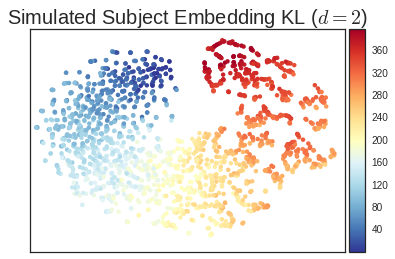

In [96]:
with sns.axes_style("white"):
    f, ax1 = plt.subplots()

# write your own visualizationb, each subject is a dot in 2D and color each subject with her own y
plotLowDimWithColor(tSNEKL_subset, subjClasses_subset, 
                    ax=ax1, plotTitle='tSNE', markerSize=20)

ax1.set_xlim([-20,18])
ax1.set_ylim([-18,18])
ax1.set_title('Simulated Subject Embedding KL ($d=2$)',fontsize=20)
f.savefig("tsne-kl.pdf")

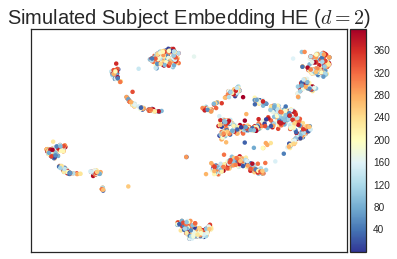

In [101]:
with sns.axes_style("white"):
    f, ax1 = plt.subplots()

# write your own visualizationb, each subject is a dot in 2D and color each subject with her own y
plotLowDimWithColor(tSNEHE_subset, subjClasses_subset, 
                    ax=ax1, plotTitle='tSNE', markerSize=20)

ax1.set_xlim([-21,16])
ax1.set_ylim([-20,16])
ax1.set_title('Simulated Subject Embedding HE ($d=2$)',fontsize=20)

f.savefig("tsne-he.pdf")

In [63]:
# ========== extracting higher dim features per subject
clf = LocallyLinearEmbedding(n_components=100)
LLE_modified_KL = clf.fit_transform(hidimKL)   # this is your X, ie your feature per subject
LLE_modified_HE = clf.fit_transform(hidimHE)

print LLE_modified_KL.shape
print LLE_modified_HE.shape

(2000, 100)
(2000, 100)


In [64]:
# ======== Regression
numPCA_comp = 60
colNameList = []
for numDim in range(2,numPCA_comp,4):
    colNameList.append(['LLE_modified_f%d'%i for i in range(numDim)])

score_r2DictList = {}
p_r2DictList = {}
accScoreDictList = {}
p_accDictList = {}    
    
featureName = 'histFHOG_largeRange_setting1'
score_r2DictList[featureName] = []
p_r2DictList[featureName] = []
accScoreDictList[featureName] = []
p_accDictList[featureName] = []

print len(colNameList)

15


In [109]:
# Helper functions
def evalFeatures_Regression(XTrain,yTrain,XTest,yTest,m):
    """
    evaluate a regression model
    """

    # scaling
    stdScaler = StandardScaler()
    stdScaler.fit(XTrain)
    XTrain = stdScaler.transform(XTrain)
    yTrain = np.log10(yTrain)
    XTest = stdScaler.transform(XTest)
    yTest = np.log10(yTest)
        
    m.fit(XTrain, yTrain)
    pred_y = m.predict(XTest)
    r2 = metrics.r2_score(yTest, pred_y)
    s = metrics.mean_squared_error(yTest, pred_y)
    return r2, s, pred_y

In [67]:
for colName in colNameList:
    #---------------------  Compute BOW
    t0 = time.clock()
    print "computing bag of words ......"
    feats = Features(subjFeatures)      # here the data is your patient patch data - list of patch features
    bow = BagOfWords(KMeans(n_clusters=len(colName), max_iter=100, n_init=2))
    bowized = bow.fit_transform(feats)
    print "Bag of words computed!"
    print time.time() - t0
    
    X_KL = LLE_modified_KL[:,:len(colName)]
    X_HE = LLE_modified_HE[:,:len(colName)]
    
    print "Shape of bow: " + str(bowized.shape)
    print "Column name: " + str(colName)
    print "Len(colName): " + str(len(colName))
    print "X.shape: " + str(X_KL.shape)

    # make a cross-validation object
    cv = KFold(n=len(subjClasses), n_folds=50, shuffle=False, random_state=0)

    ### regression
    allXy = {}    
    yName = 'FEV1pp_utah'    

    
#     allXy['SimulatedNNFeats'] = (X,y)
#     allXy['BOW'] = (bowized,y)
    y = np.asarray(subjClasses)  # loaded earlier as the number of abnormal nodes in the subject
    allXy['Ours-KL'] = (X_KL, y)   # lle_modified
    allXy['Ours-HE'] = (X_HE, y)
    allXy['BOW'] = (bowized, y)    # replaced y with subjList


    score_r2Dict = {}
    p_r2Dict = {}
    for k in allXy.keys():         
        #clf = linear_model.Ridge(alpha=1)
        score_r2Dict[k] = [] 
        #score_r2Dict[k] = cross_val_score(clf, allXy[k][0], allXy[k][1], cv=50, scoring='r2_score')
        print "working on ",k, "...."
        for i, (train, test) in enumerate(cv):
            clf = linear_model.Ridge(alpha=1)
            r2,s = evalFeatures_Regression(allXy[k][0][train],    # your X (LLE_modified)
                                           allXy[k][1][train],    # your y 
                                           allXy[k][0][test],     # your X
                                           allXy[k][1][test],clf) # your y
            score_r2Dict[k].append(r2)

    # add the results to a list
    score_r2DictList[featureName].append(score_r2Dict)
#     p_r2DictList[featureName].append(p_r2Dict)
#     accScoreDictList[featureName].append(accScoreDict)
#     p_accDictList[featureName].append(p_accDict)
    

resultsRoot = './simulatedData/evaluation'
pk.dump( score_r2DictList, open(resultsRoot + "/linReg_score_r2DictList_v2.p",'wb') )
# pk.dump( p_r2DictList, open(resultsRoot + "/linReg_p_r2DictList.p",'wb') )
# pk.dump( accScoreDictList, open(hellingerRoot + "/linReg_accScoreDictList.p",'wb') )
# pk.dump( p_accDictList, open(hellingerRoot + "/linReg_p_accDictList.p",'wb') )

computing bag of words ......
Bag of words computed!
1481159546.96
Shape of bow: (2000, 2)
Column name: ['LLE_modified_f0', 'LLE_modified_f1']
Len(colName): 2
X.shape: (2000, 2)
working on  Ours-HE ....
working on  Ours-KL ....
working on  BOW ....
computing bag of words ......


/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

Bag of words computed!
1481159542.78
Shape of bow: (2000, 6)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5']
Len(colName): 6
X.shape: (2000, 6)
working on  Ours-HE ....
working on  Ours-KL ....
working on  BOW ....
computing bag of words ......


/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

Bag of words computed!
1481159534.51
Shape of bow: (2000, 10)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5', 'LLE_modified_f6', 'LLE_modified_f7', 'LLE_modified_f8', 'LLE_modified_f9']
Len(colName): 10
X.shape: (2000, 10)
working on  Ours-HE ....
working on  Ours-KL ....
working on  BOW ....
computing bag of words ......


/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

Bag of words computed!
1481159522.56
Shape of bow: (2000, 14)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5', 'LLE_modified_f6', 'LLE_modified_f7', 'LLE_modified_f8', 'LLE_modified_f9', 'LLE_modified_f10', 'LLE_modified_f11', 'LLE_modified_f12', 'LLE_modified_f13']
Len(colName): 14
X.shape: (2000, 14)
working on  Ours-HE ....
working on  Ours-KL ....
working on  BOW ....
computing bag of words ......


/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

Bag of words computed!
1481159510.19
Shape of bow: (2000, 18)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5', 'LLE_modified_f6', 'LLE_modified_f7', 'LLE_modified_f8', 'LLE_modified_f9', 'LLE_modified_f10', 'LLE_modified_f11', 'LLE_modified_f12', 'LLE_modified_f13', 'LLE_modified_f14', 'LLE_modified_f15', 'LLE_modified_f16', 'LLE_modified_f17']
Len(colName): 18
X.shape: (2000, 18)
working on  Ours-HE ....
working on  Ours-KL ....
working on  BOW ....
computing bag of words ......


/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

Bag of words computed!
1481159515.24
Shape of bow: (2000, 22)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5', 'LLE_modified_f6', 'LLE_modified_f7', 'LLE_modified_f8', 'LLE_modified_f9', 'LLE_modified_f10', 'LLE_modified_f11', 'LLE_modified_f12', 'LLE_modified_f13', 'LLE_modified_f14', 'LLE_modified_f15', 'LLE_modified_f16', 'LLE_modified_f17', 'LLE_modified_f18', 'LLE_modified_f19', 'LLE_modified_f20', 'LLE_modified_f21']
Len(colName): 22
X.shape: (2000, 22)
working on  Ours-HE ....
working on  Ours-KL ....
working on  BOW ....


/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

computing bag of words ......
Bag of words computed!
1481159515.69
Shape of bow: (2000, 26)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5', 'LLE_modified_f6', 'LLE_modified_f7', 'LLE_modified_f8', 'LLE_modified_f9', 'LLE_modified_f10', 'LLE_modified_f11', 'LLE_modified_f12', 'LLE_modified_f13', 'LLE_modified_f14', 'LLE_modified_f15', 'LLE_modified_f16', 'LLE_modified_f17', 'LLE_modified_f18', 'LLE_modified_f19', 'LLE_modified_f20', 'LLE_modified_f21', 'LLE_modified_f22', 'LLE_modified_f23', 'LLE_modified_f24', 'LLE_modified_f25']
Len(colName): 26
X.shape: (2000, 26)
working on  Ours-HE ....
working on  Ours-KL ....
working on  BOW ....


/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

computing bag of words ......
Bag of words computed!
1481159523.9
Shape of bow: (2000, 30)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5', 'LLE_modified_f6', 'LLE_modified_f7', 'LLE_modified_f8', 'LLE_modified_f9', 'LLE_modified_f10', 'LLE_modified_f11', 'LLE_modified_f12', 'LLE_modified_f13', 'LLE_modified_f14', 'LLE_modified_f15', 'LLE_modified_f16', 'LLE_modified_f17', 'LLE_modified_f18', 'LLE_modified_f19', 'LLE_modified_f20', 'LLE_modified_f21', 'LLE_modified_f22', 'LLE_modified_f23', 'LLE_modified_f24', 'LLE_modified_f25', 'LLE_modified_f26', 'LLE_modified_f27', 'LLE_modified_f28', 'LLE_modified_f29']
Len(colName): 30
X.shape: (2000, 30)
working on  Ours-HE ....
working on  Ours-KL ....
working on  BOW ....


/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

computing bag of words ......
Bag of words computed!
1481159535.06
Shape of bow: (2000, 34)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5', 'LLE_modified_f6', 'LLE_modified_f7', 'LLE_modified_f8', 'LLE_modified_f9', 'LLE_modified_f10', 'LLE_modified_f11', 'LLE_modified_f12', 'LLE_modified_f13', 'LLE_modified_f14', 'LLE_modified_f15', 'LLE_modified_f16', 'LLE_modified_f17', 'LLE_modified_f18', 'LLE_modified_f19', 'LLE_modified_f20', 'LLE_modified_f21', 'LLE_modified_f22', 'LLE_modified_f23', 'LLE_modified_f24', 'LLE_modified_f25', 'LLE_modified_f26', 'LLE_modified_f27', 'LLE_modified_f28', 'LLE_modified_f29', 'LLE_modified_f30', 'LLE_modified_f31', 'LLE_modified_f32', 'LLE_modified_f33']
Len(colName): 34
X.shape: (2000, 34)
working on  Ours-HE ....
working on  Ours-KL ....
working on  BOW ....


/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

computing bag of words ......
Bag of words computed!
1481159540.25
Shape of bow: (2000, 38)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5', 'LLE_modified_f6', 'LLE_modified_f7', 'LLE_modified_f8', 'LLE_modified_f9', 'LLE_modified_f10', 'LLE_modified_f11', 'LLE_modified_f12', 'LLE_modified_f13', 'LLE_modified_f14', 'LLE_modified_f15', 'LLE_modified_f16', 'LLE_modified_f17', 'LLE_modified_f18', 'LLE_modified_f19', 'LLE_modified_f20', 'LLE_modified_f21', 'LLE_modified_f22', 'LLE_modified_f23', 'LLE_modified_f24', 'LLE_modified_f25', 'LLE_modified_f26', 'LLE_modified_f27', 'LLE_modified_f28', 'LLE_modified_f29', 'LLE_modified_f30', 'LLE_modified_f31', 'LLE_modified_f32', 'LLE_modified_f33', 'LLE_modified_f34', 'LLE_modified_f35', 'LLE_modified_f36', 'LLE_modified_f37']
Len(colName): 38
X.shape: (2000, 38)
working on  Ours-HE ....
working on  Ours-KL ....
working on  BOW ....


/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

computing bag of words ......
Bag of words computed!
1481159530.78
Shape of bow: (2000, 42)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5', 'LLE_modified_f6', 'LLE_modified_f7', 'LLE_modified_f8', 'LLE_modified_f9', 'LLE_modified_f10', 'LLE_modified_f11', 'LLE_modified_f12', 'LLE_modified_f13', 'LLE_modified_f14', 'LLE_modified_f15', 'LLE_modified_f16', 'LLE_modified_f17', 'LLE_modified_f18', 'LLE_modified_f19', 'LLE_modified_f20', 'LLE_modified_f21', 'LLE_modified_f22', 'LLE_modified_f23', 'LLE_modified_f24', 'LLE_modified_f25', 'LLE_modified_f26', 'LLE_modified_f27', 'LLE_modified_f28', 'LLE_modified_f29', 'LLE_modified_f30', 'LLE_modified_f31', 'LLE_modified_f32', 'LLE_modified_f33', 'LLE_modified_f34', 'LLE_modified_f35', 'LLE_modified_f36', 'LLE_modified_f37', 'LLE_modified_f38', 'LLE_modified_f39', 'LLE_modified_f40', 'LLE_modified_f41']
Len(colName): 42
X.shape: (2000, 42)
working on  Ours-HE ....
wo

/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

computing bag of words ......
Bag of words computed!
1481159498.55
Shape of bow: (2000, 46)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5', 'LLE_modified_f6', 'LLE_modified_f7', 'LLE_modified_f8', 'LLE_modified_f9', 'LLE_modified_f10', 'LLE_modified_f11', 'LLE_modified_f12', 'LLE_modified_f13', 'LLE_modified_f14', 'LLE_modified_f15', 'LLE_modified_f16', 'LLE_modified_f17', 'LLE_modified_f18', 'LLE_modified_f19', 'LLE_modified_f20', 'LLE_modified_f21', 'LLE_modified_f22', 'LLE_modified_f23', 'LLE_modified_f24', 'LLE_modified_f25', 'LLE_modified_f26', 'LLE_modified_f27', 'LLE_modified_f28', 'LLE_modified_f29', 'LLE_modified_f30', 'LLE_modified_f31', 'LLE_modified_f32', 'LLE_modified_f33', 'LLE_modified_f34', 'LLE_modified_f35', 'LLE_modified_f36', 'LLE_modified_f37', 'LLE_modified_f38', 'LLE_modified_f39', 'LLE_modified_f40', 'LLE_modified_f41', 'LLE_modified_f42', 'LLE_modified_f43', 'LLE_modified_f44', 'LLE

/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

computing bag of words ......
Bag of words computed!
1481159480.11
Shape of bow: (2000, 50)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5', 'LLE_modified_f6', 'LLE_modified_f7', 'LLE_modified_f8', 'LLE_modified_f9', 'LLE_modified_f10', 'LLE_modified_f11', 'LLE_modified_f12', 'LLE_modified_f13', 'LLE_modified_f14', 'LLE_modified_f15', 'LLE_modified_f16', 'LLE_modified_f17', 'LLE_modified_f18', 'LLE_modified_f19', 'LLE_modified_f20', 'LLE_modified_f21', 'LLE_modified_f22', 'LLE_modified_f23', 'LLE_modified_f24', 'LLE_modified_f25', 'LLE_modified_f26', 'LLE_modified_f27', 'LLE_modified_f28', 'LLE_modified_f29', 'LLE_modified_f30', 'LLE_modified_f31', 'LLE_modified_f32', 'LLE_modified_f33', 'LLE_modified_f34', 'LLE_modified_f35', 'LLE_modified_f36', 'LLE_modified_f37', 'LLE_modified_f38', 'LLE_modified_f39', 'LLE_modified_f40', 'LLE_modified_f41', 'LLE_modified_f42', 'LLE_modified_f43', 'LLE_modified_f44', 'LLE

/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

computing bag of words ......
Bag of words computed!
1481159532.7
Shape of bow: (2000, 54)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5', 'LLE_modified_f6', 'LLE_modified_f7', 'LLE_modified_f8', 'LLE_modified_f9', 'LLE_modified_f10', 'LLE_modified_f11', 'LLE_modified_f12', 'LLE_modified_f13', 'LLE_modified_f14', 'LLE_modified_f15', 'LLE_modified_f16', 'LLE_modified_f17', 'LLE_modified_f18', 'LLE_modified_f19', 'LLE_modified_f20', 'LLE_modified_f21', 'LLE_modified_f22', 'LLE_modified_f23', 'LLE_modified_f24', 'LLE_modified_f25', 'LLE_modified_f26', 'LLE_modified_f27', 'LLE_modified_f28', 'LLE_modified_f29', 'LLE_modified_f30', 'LLE_modified_f31', 'LLE_modified_f32', 'LLE_modified_f33', 'LLE_modified_f34', 'LLE_modified_f35', 'LLE_modified_f36', 'LLE_modified_f37', 'LLE_modified_f38', 'LLE_modified_f39', 'LLE_modified_f40', 'LLE_modified_f41', 'LLE_modified_f42', 'LLE_modified_f43', 'LLE_modified_f44', 'LLE_

/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

computing bag of words ......
Bag of words computed!
1481159526.86
Shape of bow: (2000, 58)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5', 'LLE_modified_f6', 'LLE_modified_f7', 'LLE_modified_f8', 'LLE_modified_f9', 'LLE_modified_f10', 'LLE_modified_f11', 'LLE_modified_f12', 'LLE_modified_f13', 'LLE_modified_f14', 'LLE_modified_f15', 'LLE_modified_f16', 'LLE_modified_f17', 'LLE_modified_f18', 'LLE_modified_f19', 'LLE_modified_f20', 'LLE_modified_f21', 'LLE_modified_f22', 'LLE_modified_f23', 'LLE_modified_f24', 'LLE_modified_f25', 'LLE_modified_f26', 'LLE_modified_f27', 'LLE_modified_f28', 'LLE_modified_f29', 'LLE_modified_f30', 'LLE_modified_f31', 'LLE_modified_f32', 'LLE_modified_f33', 'LLE_modified_f34', 'LLE_modified_f35', 'LLE_modified_f36', 'LLE_modified_f37', 'LLE_modified_f38', 'LLE_modified_f39', 'LLE_modified_f40', 'LLE_modified_f41', 'LLE_modified_f42', 'LLE_modified_f43', 'LLE_modified_f44', 'LLE

/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

In [68]:
# read in the previously saved data
resultsRoot = './simulatedData/evaluation'
# with open(resultsRoot + "/linReg_score_r2DictList.p", "rb") as f:
with open(resultsRoot + "/linReg_score_r2DictList_v2.p", "rb") as f:
    scoresDict = pk.load(f)
f.close()

# with open(resultsRoot + "/linReg_p_r2DictList.p", "rb") as f:
#     psDict = pk.load(f)
# f.close()
# plot 
# compute average of the 50 folds for score and p

In [197]:
def confidenceInterval(x, y):
    """
    Compute the confidence interval of the data
    Source: http://stackoverflow.com/questions/27164114/show-confidence-limits-and-prediction-limits-in-scatter-plot
    
    Inputs:
    - x: xAxis data
    - y: y axis data
    
    Returns
    - CI: confidence interval
    """
    import scipy.stats as stats
    p, cov = np.polyfit(x,y,1,cov=True)           # parameters and covariance from of the fit
    y_model = np.polyval(p, x)                    # model using the fit parameters; NOTE: parameters here are coefficients
    
    # Statistics
    n = y.size                              # number of observations
    m = p.size                                    # number of parameters
    DF = n - m                                    # degrees of freedom
    t = stats.t.ppf(0.95, n - m)                  # used for CI and PI bands
    
    # Estimates of Error in Data/Model
    resid = y - y_model                           
    chi2 = np.sum((resid/y_model)**2)             # chi-squared; estimates error in data
    chi2_red = chi2/(DF)                          # reduced chi-squared; measures goodness of fit
    s_err = np.sqrt(np.sum(resid**2)/(DF))        # standard deviation of the error

    x2 = np.linspace(np.min(x), np.max(x), 100)
    y2 = np.linspace(np.min(y_model), np.max(y_model), 100)

    # Confidence Interval
    CI = t*s_err*np.sqrt(1/n +(x2-np.mean(x))**2/np.sum((x-np.mean(x))**2))
    return CI

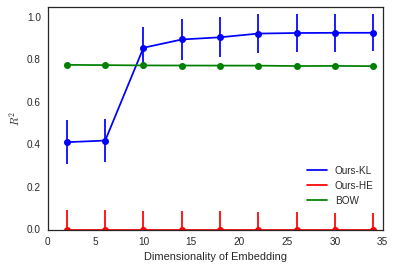

In [209]:
# read in the previously saved data
scoresList = scoresDict['histFHOG_largeRange_setting1']
# psList = psDict['histFHOG_largeRange_setting1']
# len = 21
# keys = SimulatedNNFeats, BOW (50 each for the 50 folds)

# compute average of the 50 folds for score and p value
rAvgUs = np.array([np.mean(scoresList[i]['Ours-KL']) for i in xrange(len(scoresList))])
rAvgBOW = np.array([np.mean(scoresList[i]['BOW']) for i in xrange(len(scoresList))])
rAvgHE = np.array([np.mean(scoresList[i]['Ours-HE']) for i in xrange(len(scoresList))])
rStdUs = np.array([np.std(scoresList[i]['Ours-KL']) for i in xrange(len(scoresList))])
rStdBOW = np.array([np.std(scoresList[i]['BOW']) for i in xrange(len(scoresList))])
rStdHE = np.array([np.std(scoresList[i]['Ours-HE']) for i in xrange(len(scoresList))])
xAxis = np.array([len(colNames) for colNames in colNameList])

# trying stuff with confidence interval
ciBOW = confidenceInterval(xAxis, rAvgBOW)
ciUs = confidenceInterval(xAxis, rAvgUs)
ciHE = confidenceInterval(xAxis, rAvgHE)

#limit the R for HE
rAvgHE[rAvgHE < 0] = 0.0

import matplotlib.lines as mlines

# plot the average scores
sns.set_style("white") # -- set background white
fig = plt.figure()
plt.plot(xAxis[:9], rAvgUs[:9], color='b')
plt.plot(xAxis[:9], rAvgBOW[:9], color='g')
plt.plot(xAxis[:9], rAvgHE[:9], color='r')
# plt.title("Cross Validation")
plt.ylabel(r'$R^2$')
plt.xlabel("Dimensionality of Embedding")

# add the error bars
# plt.errorbar(xAxis[:9], rAvgUs[:9], rStdUs[:9], fmt='o', color='b')
# plt.errorbar(xAxis[:9], rAvgBOW[:9], rStdBOW[:9], fmt='o', color='g')
# plt.errorbar(xAxis[:9], rAvgHE[:9], rStdHE[:9], fmt='o', color='r')
plt.errorbar(xAxis[:9], rAvgUs[:9], ciUs[:9], fmt='o', color='b', capthick=0)
plt.errorbar(xAxis[:9], rAvgBOW[:9], ciBOW[:9], fmt='o', color='g', capthick=0)
plt.errorbar(xAxis[:9], rAvgHE[:9], ciHE[:9], fmt='o', color='r', capthick=0)

# add a legend
l1 = mlines.Line2D([], [], color='b', label="Ours-KL")
l2 = mlines.Line2D([], [], color='g', label="BOW")
l3 = mlines.Line2D([], [], color='r', label="Ours-HE")
l4 = mlines.Line2D([], [], color='w', label="")
plt.legend(handles=[l1, l3, l2, l4], loc=4)

plt.ylim(0, 1.05)

# plot the average p values
plt.show()
fig.savefig("simulated-embedding-BOW-KL-HE-ci.pdf")

In [ ]:
# Figures for Vanathi
# histogram of how many abnormal nodes are present in each subject
plt.figure()
plt.hist(subjClasses)

# allXy = {}    
# yName = 'FEV1pp_utah'

# allXy['SimulatedNNFeats'] = (LLE_modified,subjList)   # is X supposed to be the patch features?
# allXy['BOW'] = (bowized,subjList)    # replaced y with subjList
# print type(allXy['SimulatedNNFeats'][1])

In [108]:
print len(xAxis)
print len(scoresList)

15
15


In [160]:
# NOT CORRECT, PRESERVED FOR REFERENCE
# Do the prediction
# set up the regression
X = LLE_modified_KL
y = np.asarray(subjClasses)

# me implementing cross validation 
testSub = []
test = np.random.permutation(len(y))
idx = 0
yPred = np.zeros((len(y)))
useCount = np.zeros((len(y)))
for i in xrange(50):
    # figure out indices for train set
    testSub = test[idx:(idx+len(y)/50)]
    train = [x for x in xrange(len(y)) if x not in testSub]
    useCount[testSub] += 1
    # train the model on the training set
    m = linear_model.Ridge(alpha=1)
    m.fit(X[train], y[train])
    yPred[testSub] = m.predict(X[testSub])
    idx = idx + len(y)/50
    
print "predicted: ", type(yPred), yPred[:10]
print "actual: ", type(y), y[:10]
print useCount.min(), useCount.max()
print "error: ", (y-yPred)[:10]
print "average error: ", np.sum(np.abs(y-yPred))/len(y)

predicted:  <type 'numpy.ndarray'> [ 251.72328966  213.0402039   148.382346    242.85981161  242.67949301
  242.03288914  288.43064012  176.00940552  167.41558558  184.3019793 ]
actual:  <type 'numpy.ndarray'> [ 316.55214771  227.31502564  102.40686375  299.91945981  292.35982025
  274.73902973  365.05625101  142.77531379  142.01701504  167.05407835]
1.0 1.0
error:  [ 64.82885804  14.27482174 -45.97548225  57.0596482   49.68032724
  32.70614058  76.62561089 -33.23409172 -25.39857053 -17.24790095]
average error:  48.3179228452


In [173]:
# set up the regression
X = LLE_modified_KL
y = np.asarray(subjClasses)

cv = KFold(n=len(subjClasses), n_folds=50, shuffle=False, random_state=0)
testPredict = np.zeros((len(y)))

for i, (train, test) in enumerate(cv):
    lr = linear_model.Ridge(alpha=1)
    lr.fit( X[train], y[train] )
    testPredict[test] =  lr.predict(X[test])
    
print "predicted: ", type(testPredict), testPredict[:10]
print "actual: ", type(y), y[:10]

predicted:  <type 'numpy.ndarray'> [ 251.91029817  212.31229521  149.01917752  243.22116232  242.12238191
  242.15914676  289.46399353  176.33911656  167.89502584  183.74753444]
actual:  <type 'numpy.ndarray'> [ 316.55214771  227.31502564  102.40686375  299.91945981  292.35982025
  274.73902973  365.05625101  142.77531379  142.01701504  167.05407835]


In [177]:
# save the regression results (prediction)
import h5py

fn = "./simulatedData/interpretation/predictions.hdf5"
with h5py.File(fn, 'w') as hf:
    ds = hf.create_dataset("predictions", [len(testPredict)], compression='gzip', compression_opts=9, data=testPredict)

print "Predictions saved"

Predictions saved


In [184]:
# loading the predictions (for reference)
with h5py.File(fn, 'r') as hf:
    predictions = np.array(hf.get("predictions"))
    
print type(predictions)

<type 'numpy.ndarray'>


In [185]:
# save kernelKL because oops
kernelFN = "./simulatedData/kernel-kl"
np.savez(kernelFN, similarities=kernelKL)

In [187]:
loader = np.load(kernelFN+".npz")
kernelLoaded = loader['similarities']
print (kernelLoaded == kernelKL).all()

True


In [188]:
print kernelLoaded

[[ 1.74616921  0.72699445  0.17005035 ...,  0.28613478  0.6392349
   0.66806149]
 [ 0.72699445  1.66733456  0.77085781 ...,  0.90367144  1.05168152
   1.05593348]
 [ 0.17005035  0.77085781  1.55396378 ...,  1.06609631  0.91585028
   0.88772106]
 ..., 
 [ 0.28613478  0.90367144  1.06609631 ...,  1.59860349  1.00893068
   0.95036644]
 [ 0.6392349   1.05168152  0.91585028 ...,  1.00893068  1.69010019
   1.06877851]
 [ 0.66806149  1.05593348  0.88772106 ...,  0.95036644  1.06877851
   1.69954538]]
